In [ ]:
!git clone https://github.com/heshdananjanee/braille_read.git

Cloning into 'braille_read'...


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time


In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = "https://www.kaggle.com/datasets/shanks0465/braille-character-dataset"

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"heshara","key":"018fef44fb739227771521ba9349fe8e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
od.download("https://www.kaggle.com/datasets/shanks0465/braille-character-dataset")

Dataset URL: https://www.kaggle.com/datasets/shanks0465/braille-character-dataset


100%|██████████| 1.30M/1.30M [00:00<00:00, 1.85MB/s]


In [ ]:
import os
import pandas as pd
from shutil import copyfile

In [ ]:
os.makedirs('./images/', exist_ok=True)   #store image files in images folder
alpha = 'a'
for i in range(0, 26):
    os.makedirs('./images/' + alpha, exist_ok=True)
    alpha = chr(ord(alpha) + 1)    #loop progress tocreate 26 folders

rootdir = '/content/braille-character-dataset/Braille Dataset/Braille Dataset/'   ##path to the source image files
for file in os.listdir(rootdir):
  file_path = os.path.join(rootdir, file)

  if os.path.isfile(file_path):
         # Extract first letter from filename
         letter = file[0]

         # Copy the file to the destination directory
         copyfile(file_path, f'./images/{letter}/{file}')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20,
                             shear_range=10,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory('./images/',
                                              target_size=(28,28),
                                              subset='training')

val_generator = datagen.flow_from_directory('./images/',
                                            target_size=(28,28),
                                            subset='validation')

Found 1248 images belonging to 26 classes.
Found 312 images belonging to 26 classes.


In [ ]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.preprocessing.image import load_img

K.clear_session()    #clear the keras session

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)  #It saves the model after every epoch if it is the best model so far based on the validation loss.
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0) # It reduces the learning rate when a metric has stopped improving.
early_stop = EarlyStopping(patience=15,verbose=1)  #stops training when a monitored metric has stopped improving.

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(64,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(128,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(256,(2,2),activation='relu')(x)
x = L.GlobalMaxPooling2D()(x)
x = L.Dense(256)(x)
x = L.LeakyReLU()(x)
x = L.Dense(64,kernel_regularizer=l2(2e-4))(x)
x = L.LeakyReLU()(x)
x = L.Dense(26,activation='softmax')(x)

model = Model(entry,x) #The model is compiled with categorical cross-entropy loss, Adam optimizer, and accuracy as the evaluation metric.
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

#train the model
history = model.fit_generator(train_generator,
                              validation_data=val_generator,
                              epochs=666,
                              callbacks=[model_ckpt,reduce_lr,early_stop],
                              verbose=1)

<ipython-input-12-d6570bd438f3>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/666
39/39 [==============================] - 5s 83ms/step - loss: 3.2716 - accuracy: 0.0521 - val_loss: 3.2154 - val_accuracy: 0.0481 - lr: 0.0010
Epoch 2/666
 1/39 [..............................] - ETA: 3s - loss: 3.1319 - accuracy: 0.0938

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 4s 93ms/step - loss: 2.9887 - accuracy: 0.1538 - val_loss: 2.5306 - val_accuracy: 0.2660 - lr: 0.0010
Epoch 3/666
39/39 [==============================] - 6s 156ms/step - loss: 2.1586 - accuracy: 0.3742 - val_loss: 1.7438 - val_accuracy: 0.5321 - lr: 0.0010
Epoch 4/666
39/39 [==============================] - 5s 132ms/step - loss: 1.5827 - accuracy: 0.5609 - val_loss: 1.5679 - val_accuracy: 0.5513 - lr: 0.0010
Epoch 5/666
39/39 [==============================] - 8s 196ms/step - loss: 1.3348 - accuracy: 0.6282 - val_loss: 1.1025 - val_accuracy: 0.7179 - lr: 0.0010
Epoch 6/666
39/39 [==============================] - 6s 153ms/step - loss: 1.2033 - accuracy: 0.6627 - val_loss: 1.0938 - val_accuracy: 0.6987 - lr: 0.0010
Epoch 7/666
39/39 [==============================] - 3s 65ms/step - loss: 0.9482 - accuracy: 0.7268 - val_loss: 1.2144 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 8/666
39/39 [==============================] - 3s 67ms/step - loss: 0.85

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 separable_conv2d (Separabl  (None, 26, 26, 64)        283       
 eConv2D)                                                        
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 separable_conv2d_1 (Separa  (None, 11, 11, 128)       8896      
 bleConv2D)                                                      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                        

In [ ]:
model = load_model('BrailleNet.h5')
acc = model.evaluate_generator(val_generator)[1]
print('model accuracy: {}'.format(round(acc,4)))

<ipython-input-14-11a8187ef6d0>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(val_generator)[1]


model accuracy: 0.9647


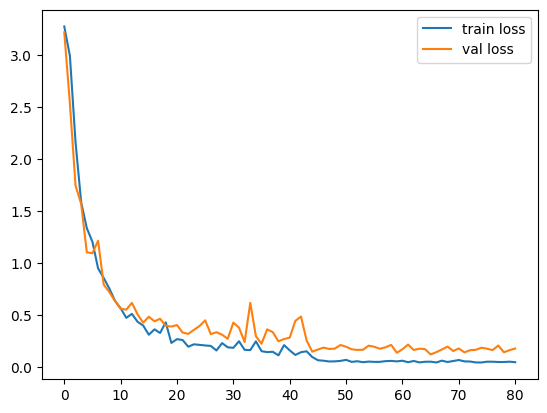

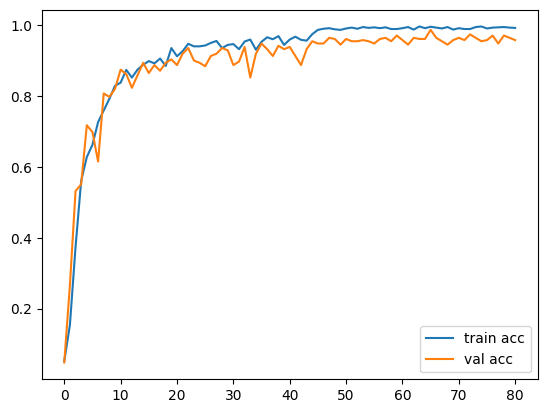

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
pred = model.predict(val_generator)
pred

10/10 [==============================] - 0s 32ms/step


array([[3.1666077e-19, 5.8591590e-11, 1.5479777e-15, ..., 4.3651839e-11,
        3.0339807e-11, 1.2832300e-12],
       [8.8136494e-01, 6.8040252e-05, 1.4819938e-03, ..., 2.7745234e-12,
        3.9379783e-17, 5.2837791e-13],
       [2.0505881e-22, 5.3102842e-15, 2.9443312e-15, ..., 4.1781560e-09,
        1.9207637e-16, 1.3542562e-13],
       ...,
       [9.1792300e-04, 9.9795616e-01, 1.8704844e-04, ..., 1.4006526e-10,
        1.2973538e-12, 2.5740418e-11],
       [5.2746259e-11, 3.5819763e-14, 1.1954054e-10, ..., 2.8077817e-05,
        1.6955670e-09, 9.8987114e-01],
       [1.0437470e-02, 8.5627247e-04, 9.8475987e-01, ..., 3.0409926e-06,
        2.0250596e-08, 5.0505808e-08]], dtype=float32)

In [ ]:
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/braille-character-dataset/Braille Dataset/Braille Dataset/a1.JPG0dim.jpg')


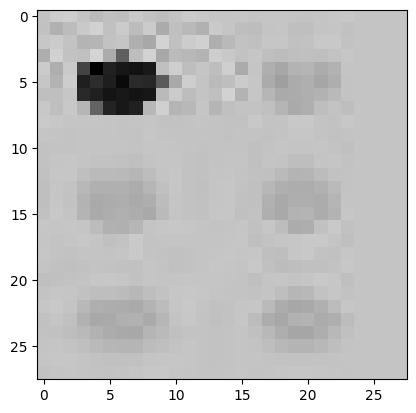

In [ ]:
plt.imshow(img)

In [ ]:
x=image.img_to_array(img)
x

array([[[194., 194., 194.],
        [204., 204., 204.],
        [206., 206., 206.],
        ...,
        [196., 196., 196.],
        [196., 196., 196.],
        [196., 196., 196.]],

       [[193., 193., 193.],
        [177., 177., 177.],
        [188., 188., 188.],
        ...,
        [196., 196., 196.],
        [196., 196., 196.],
        [196., 196., 196.]],

       [[199., 199., 199.],
        [203., 203., 203.],
        [195., 195., 195.],
        ...,
        [196., 196., 196.],
        [196., 196., 196.],
        [196., 196., 196.]],

       ...,

       [[196., 196., 196.],
        [197., 197., 197.],
        [195., 195., 195.],
        ...,
        [196., 196., 196.],
        [196., 196., 196.],
        [196., 196., 196.]],

       [[197., 197., 197.],
        [198., 198., 198.],
        [198., 198., 198.],
        ...,
        [196., 196., 196.],
        [196., 196., 196.],
        [196., 196., 196.]],

       [[194., 194., 194.],
        [196., 196., 196.],
        [197., 1

In [ ]:
x.shape

(28, 28, 3)

In [ ]:
x=np.expand_dims(x,axis=0)
model.predict(x)

1/1 [==============================] - 0s 156ms/step


array([[9.89324987e-01, 1.81284756e-03, 8.54951609e-03, 9.79729577e-08,
        5.76961838e-07, 2.40474707e-09, 2.37643172e-09, 5.17386221e-12,
        1.39614258e-05, 1.34627856e-12, 2.95039470e-04, 1.16223857e-13,
        1.20450705e-10, 4.64875118e-11, 1.48553403e-09, 7.31849373e-11,
        1.97415256e-16, 8.42407567e-12, 4.85024714e-07, 2.12411296e-17,
        2.65870608e-06, 3.62122508e-18, 2.71163182e-20, 1.18797322e-12,
        1.48509228e-20, 1.05926374e-14]], dtype=float32)

In [ ]:
a=np.argmax(model.predict(x), axis=1)
a

1/1 [==============================] - 0s 29ms/step


array([0])

In [ ]:
print(a.shape)

(1,)


In [ ]:
a=image.array_to_img(img)
a


In [ ]:
dataset_url2 = 'https://www.kaggle.com/datasets/valeryzuev/unlabeled-braille-photos'

In [ ]:
od.download('https://www.kaggle.com/datasets/valeryzuev/unlabeled-braille-photos')

Dataset URL: https://www.kaggle.com/datasets/valeryzuev/unlabeled-braille-photos


100%|██████████| 2.69G/2.69G [01:51<00:00, 26.0MB/s]


In [ ]:
braille_image_test=image.load_img('/content/unlabeled-braille-photos/1_raw/1_raw/jane_eyre/vol1/IMG_2890.JPG')

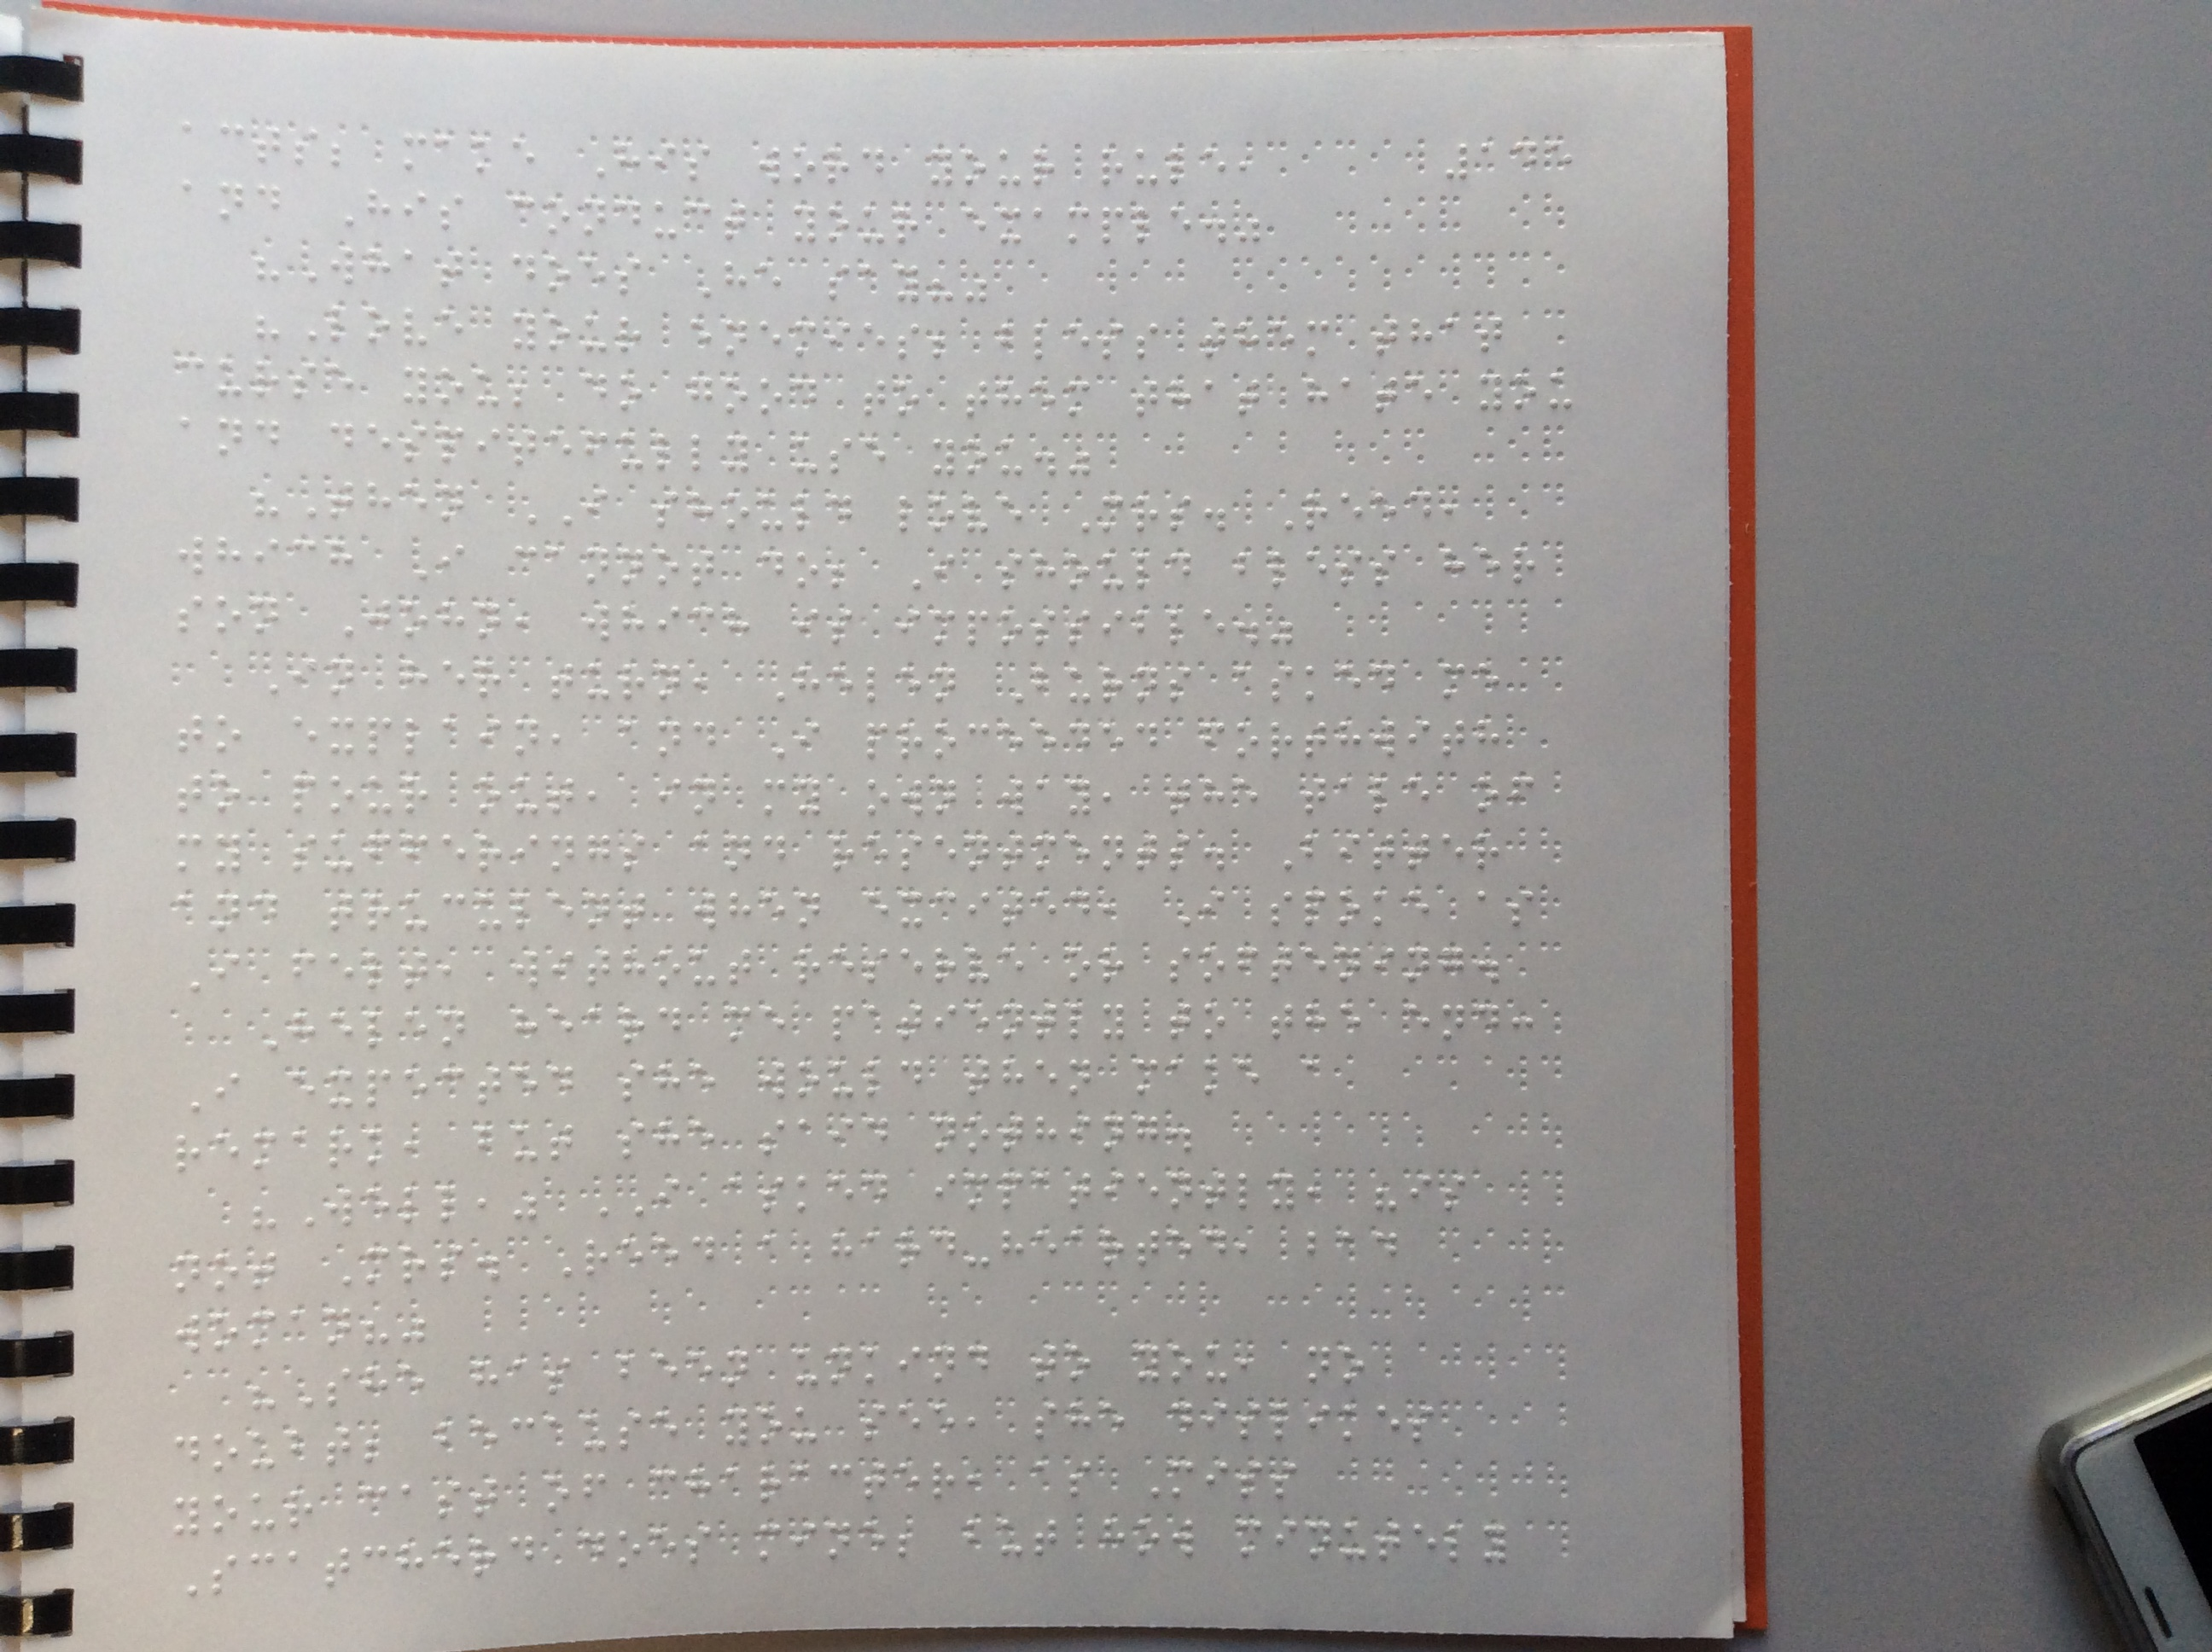

In [ ]:
braille_image_test

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
image=cv2.imread('/content/unlabeled-braille-photos/1_raw/1_raw/jane_eyre/vol1/IMG_2890.JPG')

In [ ]:
# if image is None:
#   print("there is no image")
# else:
#   #applying gaussian blur
#   blurred_image = cv2.GaussianBlur(image, (5,5), 0)
#   cv2_imshow(image)
#   cv2_imshow( blurred_image)

#   cv2.waitKey(0)
#   cv2.destroyAllWindows()

In [ ]:
#image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

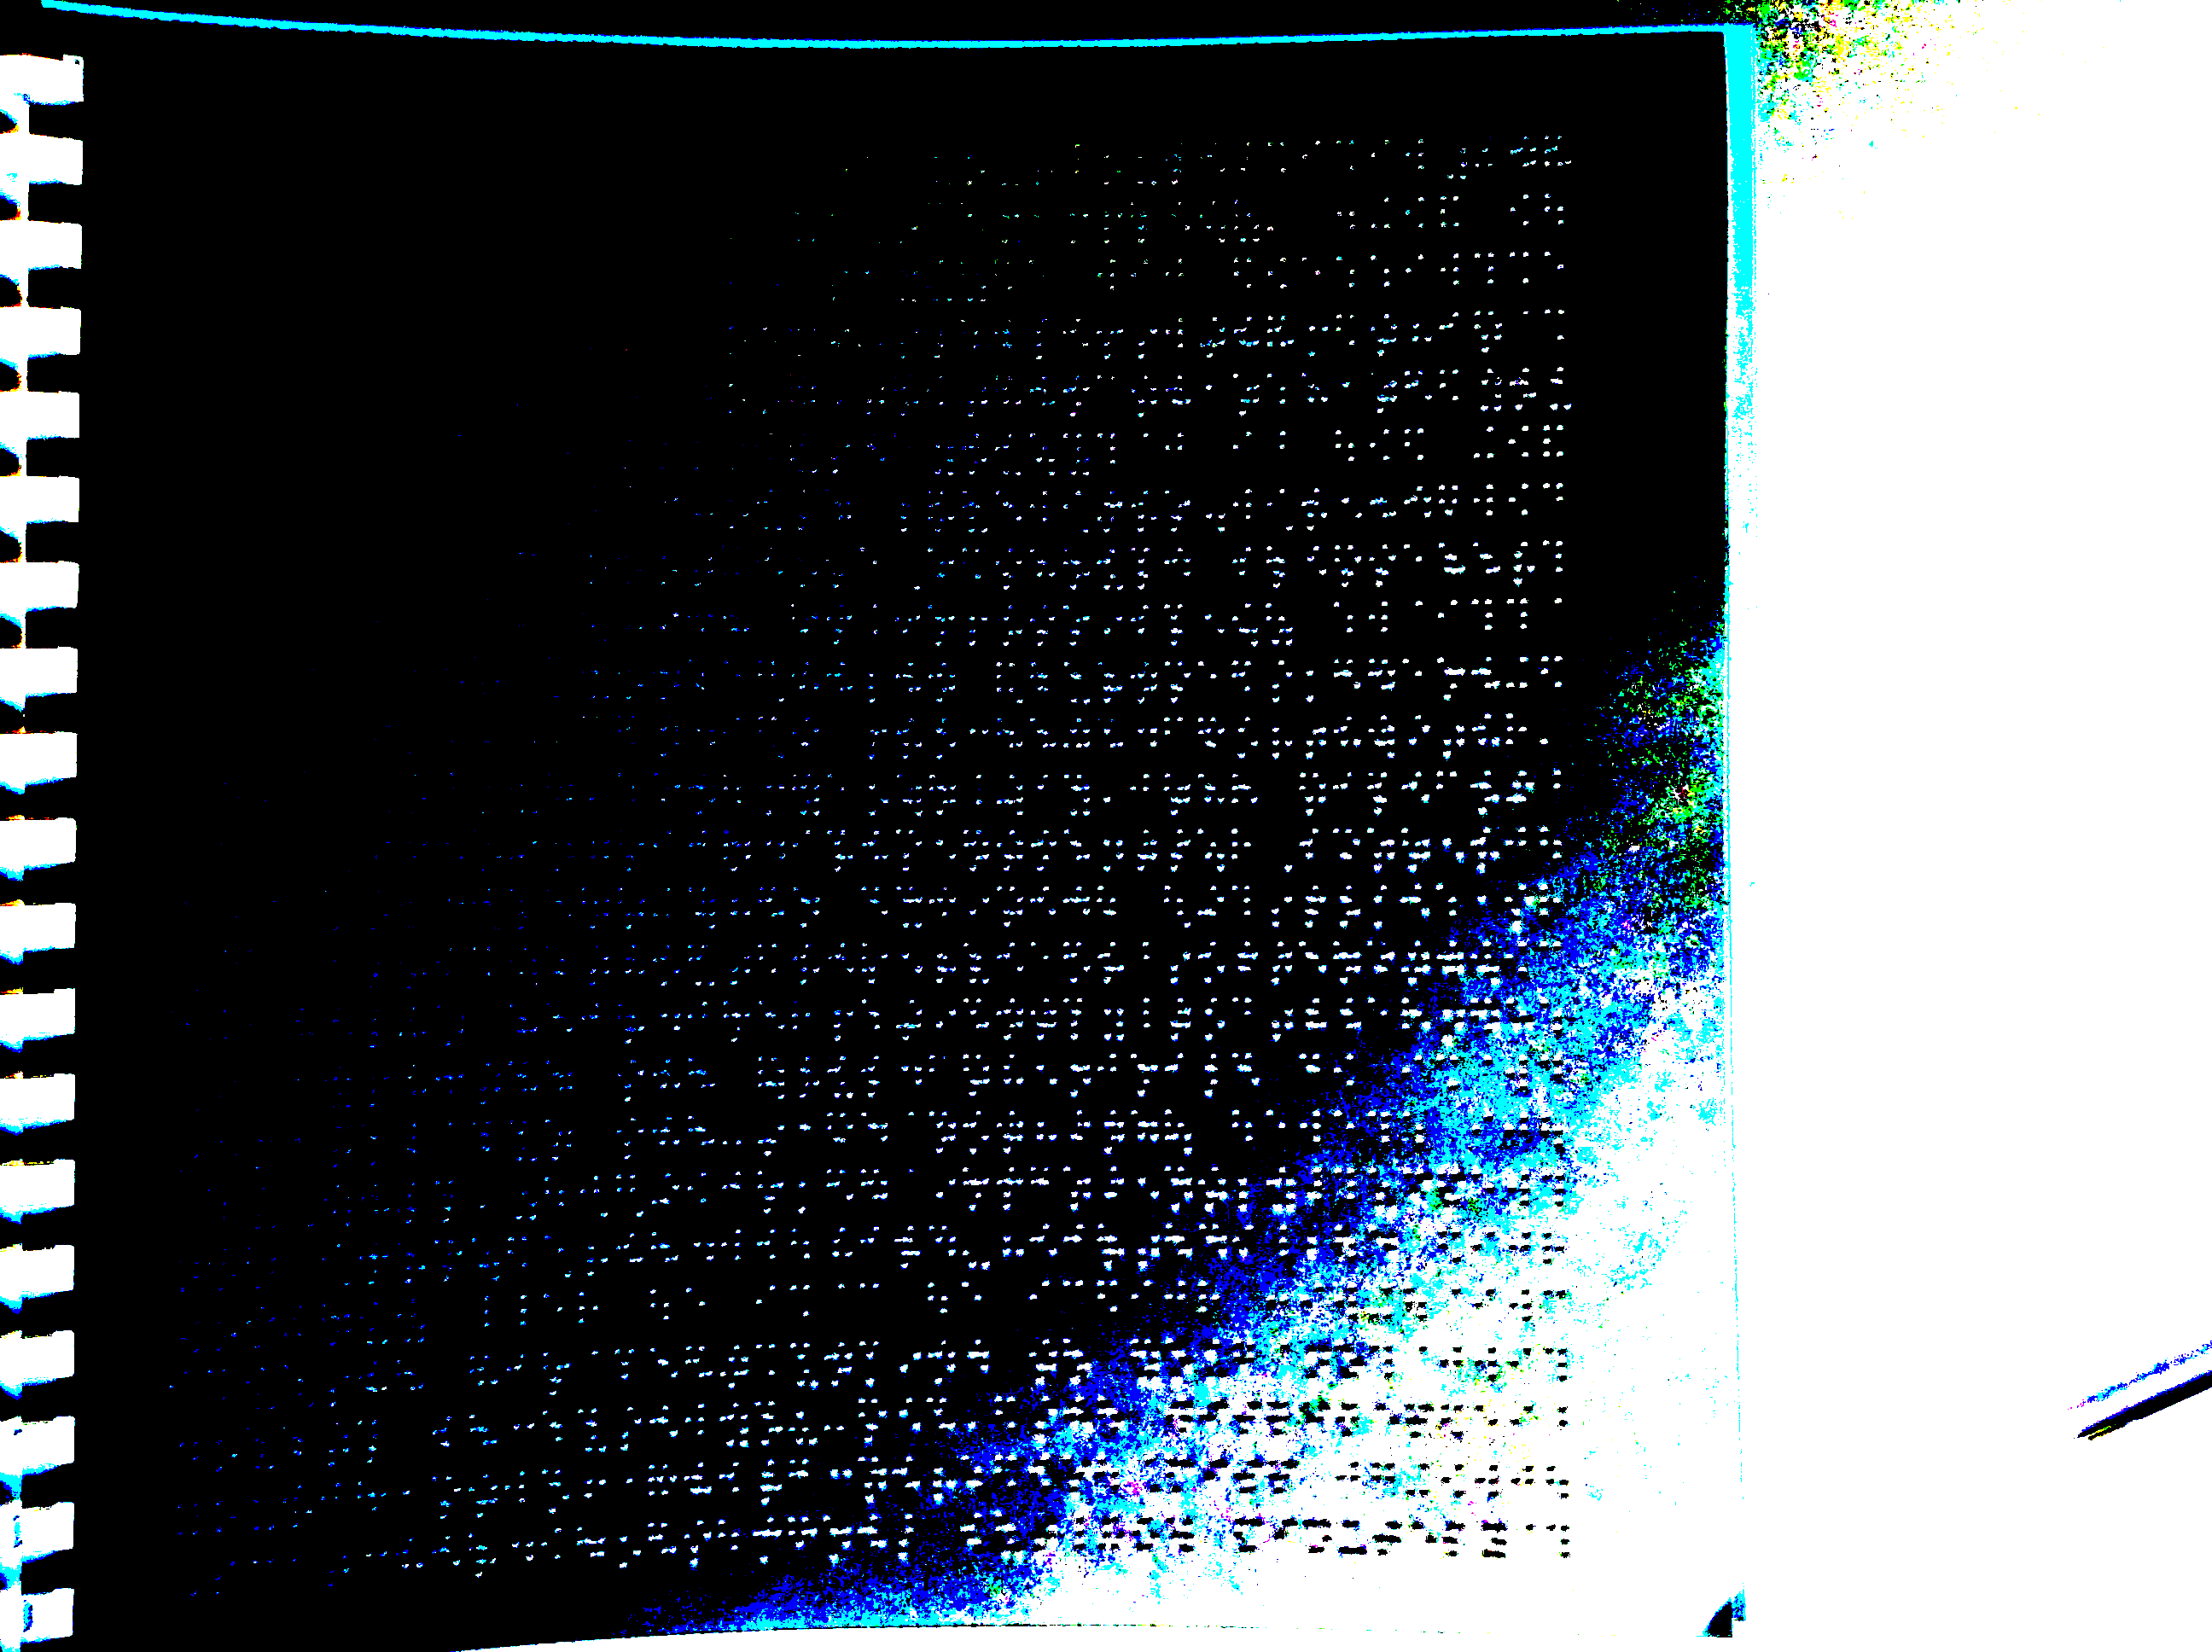

In [ ]:
import numpy as np
image = 255- image
ret, image2 = cv2.threshold(image, 110, 255, cv2.THRESH_BINARY)
blur = cv2.blur(image2,(5,5))

kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(blur,kernel,iterations = 1)
ret, thresh2 = cv2.threshold(erosion, 110, 255, cv2.THRESH_BINARY)

kernel = np.ones((3,2),np.uint8)
mask = cv2.dilate(thresh2,kernel,iterations = 1)
cv2_imshow(image2)


In [ ]:
rows, cols = mask.shape[:2]  # Take only the first two dimensions if there are more than two


In [ ]:
# kernal = np.ones((5,5), np.uint8)
# image=cv2.imread('/content/unlabeled-braille-photos/1_raw/1_raw/jane_eyre/vol1/IMG_2890.JPG')

# image1 = cv2.erode(image, kernal, iterations=1)  #apply erosion and dialation for the image
# image2 = cv2.dilate(image, kernal, iterations=1)

# cv2_imshow(image1)
# cv2_imshow(image2)

# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [ ]:
# #edge detection
# image=cv2.imread('/content/unlabeled-braille-photos/1_raw/1_raw/jane_eyre/vol1/IMG_2890.JPG')
# image1 = cv2.Canny(image,0,80)
# cv2_imshow(image1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# import numpy as np
# testing_1 = cv2.imread('/content/braille_scan.jpg')

# testing_1 = 255- testing_1
# ret, image2 = cv2.threshold(testing_1, 110, 255, cv2.THRESH_BINARY)
# blur = cv2.blur(image2,(5,5))

# kernel = np.ones((5,5),np.uint8)
# erosion = cv2.erode(blur,kernel,iterations = 1)
# ret, thresh2 = cv2.threshold(erosion, 110, 255, cv2.THRESH_BINARY)

# kernel = np.ones((3,2),np.uint8)
# mask = cv2.dilate(thresh2,kernel,iterations = 1)
# cv2_imshow(image2)

In [ ]:
# all our import statements

import time
# import platform
# import io
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# import torch
import torch
import torch.nn as nn
import torch.optim as optim

# import statements for csv dataset
import torchvision
import csv
import os
import pandas as pd
from urllib import request
import requests

# import statements for iterating over csv file
# from scipy import misc
# from io import BytesIO
# import urllib
import cv2
import numpy as np
# import tensorflow as tf
import urllib.request
# from torchvision import transforms

# import to get the alphabet
import string# Upload and read the csv files from the github repo
df = pd.read_csv("https://raw.githubusercontent.com/HelenG123/aeye-alliance/master/Labelled%20Data/ting_yi_new_dataset.csv")

In [ ]:
# generate the targets
# the targets are one hot encoding vectors

alphabet = list(string.ascii_lowercase)

target = {}

# Initalize a target dict that has the letters as its keys and as its value
# an empty one-hot encoding of size 26
for letter in alphabet:
    target[letter] = [0] * 27

# Do the one-hot encoding for each letter now
curr_pos = 0
for curr_letter in target.keys():
    target[curr_letter][curr_pos] = 1
    curr_pos += 1

# add a space as a "letter" in target
target[' '] = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
print(target)

In [40]:
# collect all data from the csv file
data=[]

# iterate over csv file
for i, row in df.iterrows():
    # store the image and label
    picture = []
    url = row['Labeled Data']
    label = row['Label']
    curr_target = target[label[11]]
    x = urllib.request.urlopen(url)
    resp = x.read()
    image = np.array(bytearray(resp), dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    # resize image to 28x28x3
    image = cv2.resize(image, (28, 28))
    # normalize to 0-1
    image = image.astype(np.float32)/255.0
    image = torch.from_numpy(image)
    picture.append(image)
    # convert the target to a long tensor
    curr_target=torch.LongTensor([curr_target])
    picture.append(curr_target)
    # append the current image & target
    data.append(picture)

In [41]:
# Create dataloader objects

# shuffle all the data
random.shuffle(data)

# batch sizes for train, test, and validation
batch_size_train = 20
batch_size_test = 5
batch_size_validation = 5

# splitting data to get training, test, and validation sets
# currently splitting my csv file only
# has 1404 in total
# 140 each for test and train
# 1124 for train
train_dataset = data[:1124]
# test has 164
test_dataset = data[1124:1264]
# validation has 164
validation_dataset = data[1264:]

# create the dataloader objects
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size_test, shuffle=False)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size_validation, shuffle=True)

In [42]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.block1 = nn.Sequential(
            #3x28x28
            nn.Conv2d(in_channels=3,
                      out_channels=16,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            #16x28x28
            nn.MaxPool2d(kernel_size=2),
            #16x14x14
            nn.LeakyReLU()
        )
        #16x14x14
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=16,
                      out_channels=32,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            #32x14x14
            nn.MaxPool2d(kernel_size=2),
            #32x7x7
            nn.LeakyReLU()
        )
        # linearly
        self.block3 = nn.Sequential(
            nn.Linear(32*7*7, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 27)
        )

        #1x27

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        # flatten the dataset
        out = out.view(out.size(0), -1)
        out = self.block3(out)

        return out


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from PIL import Image


def make_prediction(img_path):
    model = CNN()
    #model.load_state_dict(torch.load("current_model_2.pth"))
    image = Image.open(img_path)
    image = image.convert('RGB')
    width, height = image.size
    num = round(width/height/0.78)
    w = width/num

    letters=""
    for i in range (0,num):
        cropped = image.crop((i*w,0,(i+1)*w,height))
        # cropped.show()
        cropped = np.array(cropped)
        cropped = cv2.resize(cropped, (28, 28))
        cropped = cropped.astype(np.float32) / 255.0
        cropped = torch.from_numpy(cropped[None, :, :, :])
        cropped = cropped.permute(0, 3, 1, 2)
        predicted_tensor = model(cropped)
        _, predicted_letter = torch.max(predicted_tensor, 1)
        if int(predicted_letter) == 26:
            letters=letters+str(chr(32))
        else:
            letters = letters + str(chr(97 + predicted_letter))
            # letters.append(chr(97 + predicted_letter))

    return letters




    image = np.array(image)
    image = cv2.resize(image, (28, 28))
    image = image.astype(np.float32) / 255.0
    image = torch.from_numpy(image[None, :, :, :])
    image = image.permute(0, 3, 1, 2)
    predicted_tensor = model(image)
    _, predicted_letter = torch.max(predicted_tensor, 1)
    # for testing:
    print(chr(97+predicted_letter))
    return chr(97+predicted_letter)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.block1 = nn.Sequential(
            # 3x28x28
            nn.Conv2d(in_channels=3,
                      out_channels=16,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            # 16x28x28
            nn.MaxPool2d(kernel_size=2),
            # 16x14x14
            nn.LeakyReLU()
        )
        # 16x14x14
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=16,
                      out_channels=32,
                      kernel_size=5,
                      stride=1,
                      padding=2),
            # 32x14x14
            nn.MaxPool2d(kernel_size=2),
            # 32x7x7
            nn.LeakyReLU()
        )
        # linearly
        self.block3 = nn.Sequential(
            nn.Linear(32 * 7 * 7, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 27)
        )

        # 1x26

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        # flatten the dataset
        out = out.view(-1, 32 * 7 * 7)
        out = self.block3(out)

        return out


# print(make_prediction("threw_the_ball.png"))
# print(make_prediction("little_girl.png"))
# print(make_prediction("with_his_family.png"))
# print(make_prediction("the_little.png"))
# print(make_prediction("the_daddy.png"))
# print(make_prediction("and_laughed.png"))
# print(make_prediction("would_run_and_get_it.png"))
# print(make_prediction("he_took_it_home_to_play.png"))
# print(make_prediction("picked_it_up_with_his_mouth.png"))

# print(make_prediction("family.jpg"))
#print(make_prediction("/content/home.jpg"))
print(make_prediction("/took.jpg"))
# print(make_prediction("would.png"))

pppp
